# 02_Preprocessing_and_Modeling

In this notebook we will build our preprocessing pipelines to handle:
1. Missing‐value imputation  
2. Categorical variable encoding  
3. Feature scaling 

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline as Pl
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPl
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from pathlib import Path


## 0. Feature Engineering

In [137]:
# Load raw CSV (semicolon-delimited) & tidy headers
df = pd.read_csv(Path('../data/data0.csv'), sep=';')
df.columns = df.columns.str.strip()

### 0.1 Raw Data Loading & Initial Cleaning

1. **Cast Categorical Codes**  
   Convert all integer-coded label columns (e.g. marital status, application mode, parental qualifications, etc.) into pandas `category` dtype for efficient storage and downstream encoding.

2. **Drop Redundant Feature**  
   Remove the `Daytime/evening attendance` column, as it is no longer needed for our analysis.

3. **Prune Semester Features**  
   From all the “Curricular units” columns, keep only the four key semester metrics (grades and approval flags for 1st and 2nd semester) and drop the rest.

After this step, the dataset is tidied and reduced to the core variables we’ll use for feature engineering and modeling.

In [138]:

# 1 ── Cast int-coded label columns to category
code_cols = [
    'Marital status','Application mode','Application order','Course',
    'Daytime/evening attendance','Previous qualification','Nacionality',
    "Mother's qualification","Father's qualification",
    'Displaced','Educational special needs','Debtor',
    'Tuition fees up to date','Gender','Scholarship holder',
    "Mother's occupation","Father's occupation",
    'International'
]
df[code_cols] = df[code_cols].astype('category')

# 2 ── Drop redundant feature
df = df.drop(columns='Daytime/evening attendance')

# 3 ── Keep only the four key semester features
keep_sem = [
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (approved)'
]
sem_cols = [c for c in df.columns if 'Curricular units' in c and c not in keep_sem]
df = df.drop(columns=sem_cols)

print('Cleaned shape:', df.shape)


Cleaned shape: (4424, 28)


### 0.2 Resulting columns

- **Numeric features** (floats)  
- **Categorical features** (integer‐coded categories)

In [139]:
cat_cols = df.select_dtypes('category').columns.tolist()         
num_cols = df.select_dtypes(['int64', 'float64']).columns.tolist()  

for lst in (cat_cols, num_cols):
    if 'Target' in lst:
        lst.remove('Target')

print("Categorical features:", cat_cols)
print("Numeric features:", num_cols)

Categorical features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Numeric features: ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [140]:
ord_cols = [
    'Previous qualification',
    "Mother's qualification",
    "Father's qualification",
    'Application order'
]

nom_cols = [c for c in cat_cols if c not in ord_cols]

print("Ordinal features :", ord_cols)
print("Nominal features :", nom_cols)

Ordinal features : ['Previous qualification', "Mother's qualification", "Father's qualification", 'Application order']
Nominal features : ['Marital status', 'Application mode', 'Course', 'Nacionality', "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


### 0.n Encode Target and Stratified Split (70/15/15)

1. **Encode the target**  
   We convert the `Target` column into numeric labels (`0, 1, ...`) using `LabelEncoder` so that our classifiers can work with it.

2. **Create stratified splits**  
   To preserve the class distribution in each subset, we perform a two‐stage stratified split:
   - **Test set (15%)**: Held out for the *final* evaluation of our models.
   - **Validation set (15% of the remaining 85%, i.e. ~12.75% of the total)**: Used for hyperparameter tuning and early stopping.
   - **Training set (remaining 70%)**: Used to fit our preprocessing pipelines and train the models.

3. **Reproducibility**  
   We set `random_state=42` in both splits to ensure that results can be reproduced.

In [141]:
# 5 ── Encode target and stratify 70/15/15
le = LabelEncoder()
y = le.fit_transform(df['Target'])
X = df.drop(columns='Target')

all_features = X.columns.tolist()

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (3096, 27) Val: (664, 27) Test: (664, 27)


We replicate the casting and feature-pruning decisions from notebook 01 so that all subsequent preprocessing steps operate on the same cleaned dataset.

## 2. Build preprocessing pipelines

- **Numeric pipeline**: impute (median) → scale (StandardScaler)  
- **Categorical pipeline**: (optional) impute constant → encode (OneHotEncoder)

In [142]:
# 0 │ Ensure ordinal columns are strings in all splits

for df_part in (X_train, X_val, X_test):
    df_part[ord_cols] = df_part[ord_cols].astype(str)


# 1 │ Custom orders

qual_order = [34, 35, 36, 37, 38, 11, 26, 30, 29, 19, 14, 10, 12,  9, 1, 27, 13, 25, 20, 18, 22, 31, 33, 39, 2, 40, 3, 41, 42, 43,4, 44, 5, 6]
qual_order_str = list(map(str, qual_order))
app_order_str  = list(map(str, range(0, 10)))

ord_enc = OrdinalEncoder(
    categories=[qual_order_str,           # Previous qualification
                qual_order_str,           # Mother's qualification
                qual_order_str,           # Father's qualification
                app_order_str],           # Application order
    dtype='int8',
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


# 2 │ Pipelines

num_pipe = Pipeline([('scaler', StandardScaler())])

ord_pipe = Pipeline([('encoder', ord_enc)])

nom_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   ])


# 3 │ ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('ord', ord_pipe, ord_cols),
        ('nom', nom_pipe, nom_cols)
    ],
    remainder='drop'
)


# 4 │ Fit-transform

X_train_preprocessed = preprocessor.fit_transform(X_train)
print("Preprocessed X_train shape:", X_train_preprocessed.shape)


Preprocessed X_train shape: (3096, 160)


## 3.1 Full pipeline & hyperparameter tuning -> Random Forest

In [143]:

selector = VarianceThreshold(threshold=0.01)

# Build the full pipeline
rf_pipe = Pl([('preproc', preprocessor), 
              ('select',  selector), 
              ('clf', RandomForestClassifier(random_state=42))])

rf_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],  # no selection vs. two levels
    'clf__n_estimators':    [100, 200],          # number of trees
    'clf__max_depth':       [None, 10, 20],      # tree depth
    'clf__class_weight':    [None, 'balanced']   # handle class imbalance
}

rf_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,    refit=True,
    error_score='raise'
)

rf_search.fit(X_train, y_train)

print("Best parameters:", rf_search.best_params_)
print("Best CV f1_macro:", rf_search.best_score_)

Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 200, 'select__threshold': 0.0}
Best CV f1_macro: 0.6984885789168798


              precision    recall  f1-score   support

     Dropout       0.82      0.69      0.75       213
    Enrolled       0.45      0.58      0.51       119
    Graduate       0.85      0.84      0.84       332

    accuracy                           0.75       664
   macro avg       0.71      0.71      0.70       664
weighted avg       0.77      0.75      0.75       664



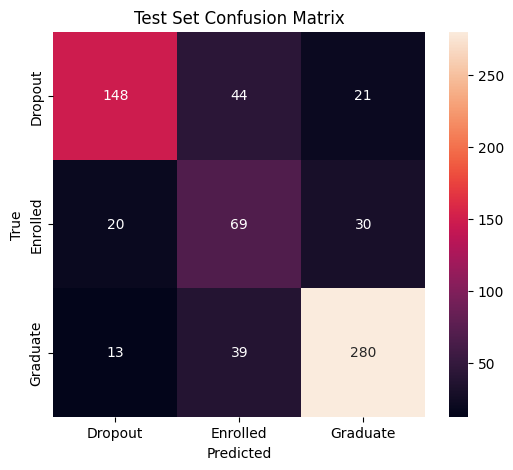

In [144]:

# Retrieve best model
best_model = rf_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.2 Full pipeline & hyperparameter tuning -> Decision Tree

In [145]:
dt_pipe = Pl([('preproc', preprocessor), ('select',  selector), ('clf', DecisionTreeClassifier(random_state=42))])

dt_param_grid = {
    'select__threshold':    [0.0, 0.005, 0.01],      # same selector choices
    'clf__max_depth':       [None, 5, 10, 20],       # tree depth
    'clf__min_samples_split': [2, 5, 10],            # controls overfitting
    'clf__class_weight':    [None, 'balanced']       # handle class imbalance
}

dt_search = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
dt_search.fit(X_train, y_train)

print("Decision Tree best params:", dt_search.best_params_)
print("Decision Tree best CV f1_macro:", dt_search.best_score_)

Decision Tree best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'select__threshold': 0.005}
Decision Tree best CV f1_macro: 0.6632784005108501


              precision    recall  f1-score   support

     Dropout       0.85      0.66      0.74       213
    Enrolled       0.41      0.64      0.50       119
    Graduate       0.83      0.78      0.80       332

    accuracy                           0.72       664
   macro avg       0.69      0.69      0.68       664
weighted avg       0.76      0.72      0.73       664



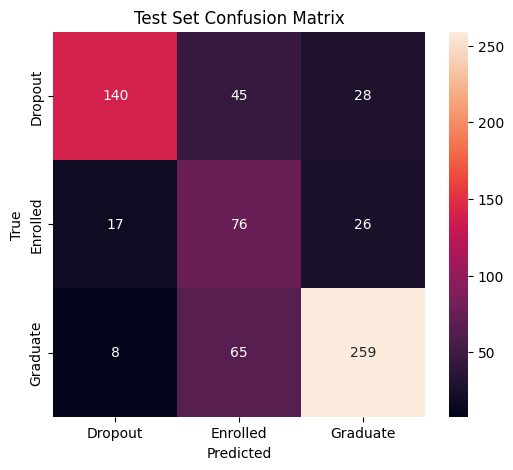

In [146]:
# Retrieve best model
best_model = dt_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.3 Full pipeline & hyperparameter tuning -> K-Nearest Neighbors

In [147]:
cat_idx = [all_features.index(c) for c in cat_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idx,
    sampling_strategy='auto',
    k_neighbors=3,
    random_state=42
)


knn_pipe = ImbPl([
    ('preproc', preprocessor),         
    ('smote',   smote_nc), 
    ('select', VarianceThreshold()),   
    ('clf', KNeighborsClassifier()) 
])

knn_param_grid = {
    'select__threshold': [0.0, 0.005, 0.01],  # selector choices
    'clf__n_neighbors': [3, 5, 7, 9],         # how many neighbors
    'clf__weights': ['uniform', 'distance'],  # weighting of votes
    'clf__p': [1, 2]                          # L1 (Manhattan) vs. L2 (Euclidean)
}

knn_search = GridSearchCV(
    knn_pipe,
    knn_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    error_score='raise'
)
knn_search.fit(X_train, y_train)

print("KNN best params:", knn_search.best_params_)
print("KNN best CV f1_macro:", knn_search.best_score_)

KNN best params: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform', 'select__threshold': 0.005}
KNN best CV f1_macro: 0.5848456842620761


Best parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__n_estimators': 200, 'select__threshold': 0.0}
              precision    recall  f1-score   support

     Dropout       0.71      0.57      0.63       213
    Enrolled       0.35      0.55      0.42       119
    Graduate       0.78      0.72      0.75       332

    accuracy                           0.64       664
   macro avg       0.61      0.61      0.60       664
weighted avg       0.68      0.64      0.65       664



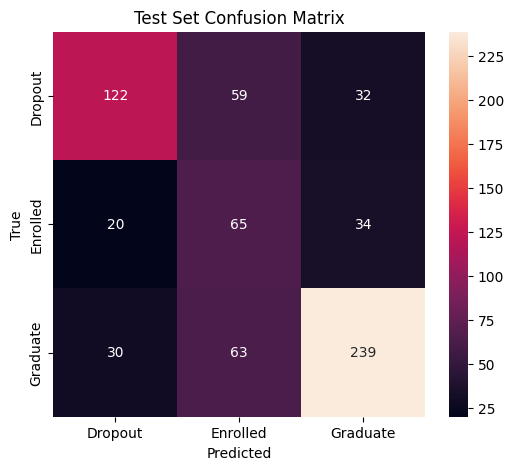

In [148]:
print("Best parameters:", rf_search.best_params_)

# Retrieve best model
best_model = knn_search.best_estimator_

# Predict on test
y_pred = best_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

## 3.4 Full pipeline & hyperparameter tuning -> HistGradientBoostingClassifier


Best HGB params: {'clf__l2_regularization': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__max_iter': 100, 'clf__max_leaf_nodes': 31}
Best CV f1_macro: 0.7089961430457393
              precision    recall  f1-score   support

     Dropout       0.81      0.66      0.73       213
    Enrolled       0.44      0.66      0.53       119
    Graduate       0.86      0.80      0.83       332

    accuracy                           0.73       664
   macro avg       0.70      0.71      0.70       664
weighted avg       0.77      0.73      0.74       664



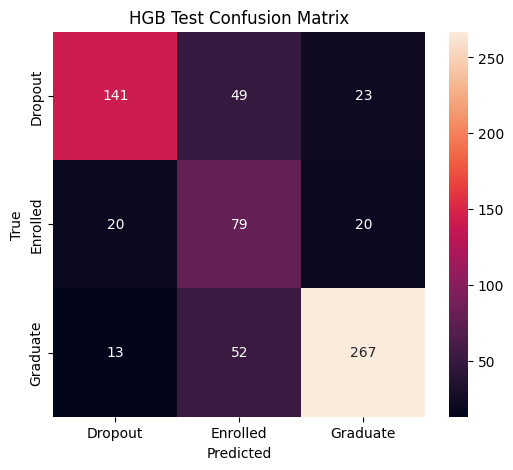

In [149]:
hgb = HistGradientBoostingClassifier(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

# 1) Build the pipeline
hgb_pipe = Pipeline([
    ('preproc', preprocessor),     
    ('select', VarianceThreshold(threshold=0.01)),
    ('clf', hgb)
])

# 2) Define a grid to search
hgb_param_grid = {
    'clf__learning_rate':     [0.01, 0.1, 0.2],
    'clf__max_iter':          [100, 200],
    'clf__max_depth':         [None, 3, 5],
    'clf__max_leaf_nodes':    [31, 63, 127],
    'clf__l2_regularization': [0.0, 1.0]
}

# 3) Compute sample weights to balance classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 4) Set up GridSearchCV
hgb_search = GridSearchCV(
    hgb_pipe,
    param_grid=hgb_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

# 5) Fit, passing the sample weights into the classifier step
hgb_search.fit(
    X_train,
    y_train,
    **{'clf__sample_weight': sample_weights}
)

print("Best HGB params:",  hgb_search.best_params_)
print("Best CV f1_macro:", hgb_search.best_score_)

# 6) Evaluate on test set
best_hgb = hgb_search.best_estimator_
y_pred   = best_hgb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('HGB Test Confusion Matrix')
plt.show()

## 3.5 Full pipeline & hyperparameter tuning -> Support Vector Machine


SVC best params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'select__threshold': 0.01}
SVC best CV f1_macro: 0.6810538329508292
              precision    recall  f1-score   support

     Dropout       0.79      0.75      0.77       213
    Enrolled       0.55      0.35      0.43       119
    Graduate       0.80      0.92      0.85       332

    accuracy                           0.77       664
   macro avg       0.71      0.68      0.68       664
weighted avg       0.75      0.77      0.75       664



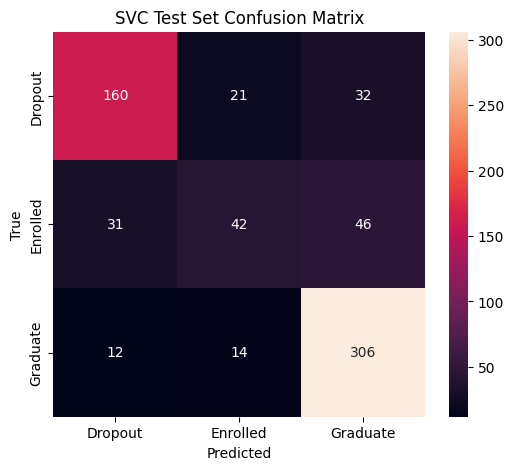

In [150]:
svc_pipe = Pl([
    ('preproc', preprocessor),
    ('select', selector),
    ('clf', SVC(random_state=42))
])

svc_param_grid = {
    'select__threshold': [0.0, 0.005, 0.01],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto'], 
    'clf__kernel': ['rbf', 'linear', 'poly']
}

svc_search = GridSearchCV(
    svc_pipe,
    svc_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True,
    refit=True,
    error_score='raise'
)

svc_search.fit(X_train, y_train)

print("SVC best params:", svc_search.best_params_)
print("SVC best CV f1_macro:", svc_search.best_score_)

y_pred_svc = svc_search.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))

# confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svc, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVC Test Set Confusion Matrix')
plt.show()

## 4. Compare Tuned Models

We now have:
- **RF** tuned via `rf_search.best_params_` 
- **Decision Tree** tuned via `dt_search.best_params_`  
- **KNN** tuned via `knn_search.best_params_`  

Next, we’ll collect their best CV F1-macro into a small table, choose the best, and run the final test‐set evaluation on that model.

In [151]:
import pandas as pd

cv_comparison = pd.DataFrame({
    'RandomForest': [rf_search.best_score_],
    'DecisionTree': [dt_search.best_score_],
    'KNN':          [knn_search.best_score_]
}, index=['CV F1-macro']).T

cv_comparison

,CV F1-macro
RandomForest,0.698489
DecisionTree,0.663278
KNN,0.584846
